In [1]:
import sys
import os

# Workaround to make packages work in both Jupyter notebook and Python
module_root_name = "AgeEstimator"
module_paths = [
    os.path.abspath(os.path.join('..')),
    os.path.abspath(os.path.join('../..')),
    os.path.abspath(os.path.join('../../..'))
]
module_paths = list(filter(lambda x: x.endswith(module_root_name), module_paths))
module_path = module_paths[0] if len(module_paths) == 1 else ""
if module_path not in sys.path:
    sys.path.append(module_path)

from server.data.dataset import DataLoader

dl = DataLoader()
x_train, y_train = dl.load_train()
x_test, y_test = dl.load_test()

In [2]:
import time
import pandas as pd
import numpy as np
from scipy.ndimage import filters
from PIL import Image, ImageFilter 
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# create csv files
df_train = pd.DataFrame(x_train, columns=['filename'])
df_train['age'] = pd.Series(y_train)
# df_train.head()

In [4]:
df_test = pd.DataFrame(x_test, columns=['filename'])
df_test['age'] = pd.Series(y_test)
# df_test.head()

In [5]:
df_train.to_csv('training_set.csv', index=False)
df_test.to_csv('test_set.csv', index=False)

In [6]:
print(f'Number of training examples: {df_train.shape[0]}')
print(f'Number of test examples: {df_test.shape[0]}')

Number of training examples: 149724
Number of test examples: 37430


In [7]:
train_max = df_train.max()['age']
test_max = df_test.max()['age']
print(train_max, test_max)

116 110


In [8]:
num_ages = np.unique(df_train['age'].values).shape[0]
print(f'Number of age labels: {num_ages}')

Number of age labels: 102


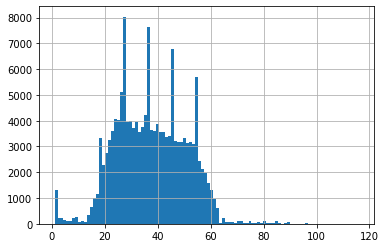

In [9]:
histogram = df_train['age'].hist(bins=df_train['age'].nunique())

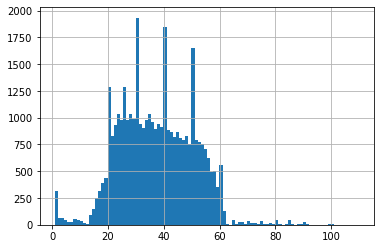

In [10]:
histogram = df_test['age'].hist(bins=df_test['age'].nunique())

In [11]:
class DatasetAge(Dataset):
    """Custom Dataset for loading images"""

    def __init__(self, csv_path, transform=None):

        df = pd.read_csv(csv_path)
        self.csv_path = csv_path
        self.df = df
        self.y = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.df.iloc[index]['filename']).convert('L')
        img = img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [12]:
TRAIN_CSV_PATH = 'training_set.csv'
TEST_CSV_PATH = 'test_set.csv'
BATCH_SIZE = 64

In [13]:
train_indices = torch.arange(0, df_train.shape[0]-1000).numpy()
valid_indices = torch.arange(df_train.shape[0]-1000, df_train.shape[0]).numpy()

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)



transform = transforms.Compose([transforms.ToTensor()])

train_dataset = DatasetAge(csv_path=TRAIN_CSV_PATH, transform=transform)
valid_dataset = DatasetAge(csv_path=TRAIN_CSV_PATH, transform=transform)
test_dataset = DatasetAge(csv_path=TEST_CSV_PATH, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,sampler=train_sampler)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,sampler=valid_sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [14]:
from torch.autograd import Variable
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super().__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [15]:
epochs = 30
inputDim = 250*250
outputDim = 121
learningRate = 0.001 

model = LogisticRegression(inputDim, outputDim)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

In [16]:
def compute_mae_mse_acc(model, data_loader):
    mae, mse, acc, num_examples = 0., 0., 0, 0
    for i, (images, labels) in enumerate(data_loader):

        images = Variable(images.view(-1, inputDim))
        labels = Variable(labels)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        num_examples += labels.size(0)
        acc += torch.sum(predicted == labels)
        mae += torch.sum(torch.abs(predicted - labels))
        mse += torch.sum((predicted - labels)**2)
    acc = acc.float() / num_examples   
    mae = mae.float() / num_examples
    mse = mse.float() / num_examples
    return mae, mse, acc

In [17]:
start_time = time.time()

l = []
train_mae_list, valid_mae_list = [], []
train_mse_list, valid_mse_list = [], []
train_acc_list, valid_acc_list = [], []

for epoch in range(int(epochs)):
    start = time.time()
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, inputDim))
        
        norm = torch.norm(images,dim=1)
        dim = list(norm.size())[0]
        norm = norm.reshape(dim, 1)
        images = images/norm
        
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        l.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if (not (i+1) % 400) or (i+1 == len(train_loader)):
            print (f'Epoch: {epoch+1:03d}/{epochs:03d} | '
                   f'Batch {i+1:03d}/{len(train_loader):03d} |' 
                   f' Loss: {loss.item():.4f}')
    with torch.set_grad_enabled(False):
        
        train_mae, train_mse, train_acc = compute_mae_mse_acc(model, train_loader)
        valid_mae, valid_mse, valid_acc = compute_mae_mse_acc(model, valid_loader)
 
        print(f'Epoch: {epoch+1:03d}/{epochs:03d}\n'
              f'Train MAE: {train_mae:.2f} | Validation MAE: {valid_mae:.2f}')
        
        train_mae_list.append(train_mae)
        valid_mae_list.append(valid_mae)
        train_mse_list.append(train_mse)
        valid_mse_list.append(valid_mse)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 400/2324 | Loss: 3.9684
Epoch: 001/050 | Batch 800/2324 | Loss: 4.0028
Epoch: 001/050 | Batch 1200/2324 | Loss: 3.9549
Epoch: 001/050 | Batch 1600/2324 | Loss: 3.9348
Epoch: 001/050 | Batch 2000/2324 | Loss: 4.0026
Epoch: 001/050 | Batch 2324/2324 | Loss: 3.9628
Epoch: 001/050
Train MAE: 11.41 | Validation MAE: 11.50
Time elapsed: 28.06 min
Epoch: 002/050 | Batch 400/2324 | Loss: 3.7954
Epoch: 002/050 | Batch 800/2324 | Loss: 3.7825
Epoch: 002/050 | Batch 1200/2324 | Loss: 3.8169
Epoch: 002/050 | Batch 1600/2324 | Loss: 3.8658
Epoch: 002/050 | Batch 2000/2324 | Loss: 3.9446
Epoch: 002/050 | Batch 2324/2324 | Loss: 3.7776
Epoch: 002/050
Train MAE: 10.69 | Validation MAE: 10.70
Time elapsed: 27.46 min
Epoch: 003/050 | Batch 400/2324 | Loss: 3.7267
Epoch: 003/050 | Batch 800/2324 | Loss: 4.0148
Epoch: 003/050 | Batch 1200/2324 | Loss: 4.0003
Epoch: 003/050 | Batch 1600/2324 | Loss: 3.7743
Epoch: 003/050 | Batch 2000/2324 | Loss: 3.7512
Epoch: 003/050 | Batch 2324/23

Epoch: 023/050 | Batch 1600/2324 | Loss: 3.5043
Epoch: 023/050 | Batch 2000/2324 | Loss: 3.3793
Epoch: 023/050 | Batch 2324/2324 | Loss: 3.4597
Epoch: 023/050
Train MAE: 11.47 | Validation MAE: 12.59
Time elapsed: 29.02 min
Epoch: 024/050 | Batch 400/2324 | Loss: 3.4253
Epoch: 024/050 | Batch 800/2324 | Loss: 3.4017
Epoch: 024/050 | Batch 1200/2324 | Loss: 3.4698
Epoch: 024/050 | Batch 1600/2324 | Loss: 3.4250
Epoch: 024/050 | Batch 2000/2324 | Loss: 3.5229
Epoch: 024/050 | Batch 2324/2324 | Loss: 3.4037
Epoch: 024/050
Train MAE: 11.13 | Validation MAE: 12.09
Time elapsed: 58.60 min
Epoch: 025/050 | Batch 400/2324 | Loss: 3.2989
Epoch: 025/050 | Batch 800/2324 | Loss: 3.3275
Epoch: 025/050 | Batch 1200/2324 | Loss: 3.4254
Epoch: 025/050 | Batch 1600/2324 | Loss: 3.5312
Epoch: 025/050 | Batch 2000/2324 | Loss: 3.4924
Epoch: 025/050 | Batch 2324/2324 | Loss: 3.4203
Epoch: 025/050
Train MAE: 11.52 | Validation MAE: 12.36
Time elapsed: 27.68 min
Epoch: 026/050 | Batch 400/2324 | Loss: 3.51

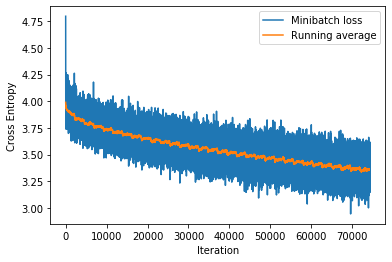

In [18]:
plt.plot(l, label='Minibatch loss')
plt.plot(np.convolve(l, np.ones(200,)/200, mode='valid'), label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

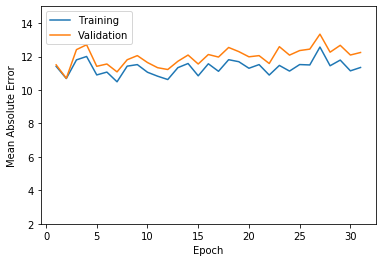

In [24]:
plt.plot(np.arange(1, 32), train_mae_list, label='Training')
plt.plot(np.arange(1, 32), valid_mae_list, label='Validation')
plt.ylim(2, 15)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

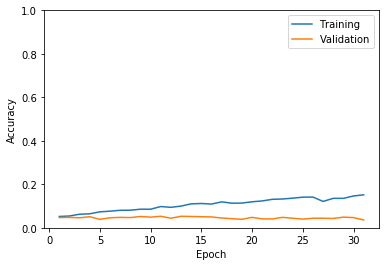

In [25]:
plt.plot(np.arange(1, 32), train_acc_list, label='Training')
plt.plot(np.arange(1, 32), valid_acc_list, label='Validation')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
with torch.set_grad_enabled(False):
    test_mae, test_mse, test_acc = compute_mae_mse_acc(model=model, data_loader=test_loader)
    
print(f'Test MAE: {test_mae:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Test ACC: {test_acc*100:.2f}%')

Test MAE: 12.65
Test MSE: 276.80
Test ACC: 4.30%


In [31]:
torch.save(model.state_dict(), 'param3')

In [27]:
model2 = LogisticRegression(inputDim, outputDim)
model2.load_state_dict(torch.load('param'))
model2.eval()

LogisticRegression(
  (linear): Linear(in_features=62500, out_features=121, bias=True)
)

In [28]:
with torch.set_grad_enabled(False):
    test_mae, test_mse, test_acc = compute_mae_mse_acc(model=model2, data_loader=test_loader)
    
print(f'Test MAE: {test_mae:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Test ACC: {test_acc*100:.2f}%')

Test MAE: 10.83
Test MSE: 211.68
Test ACC: 4.67%
